In [3]:
from rdkit.Chem import Draw
import pickle

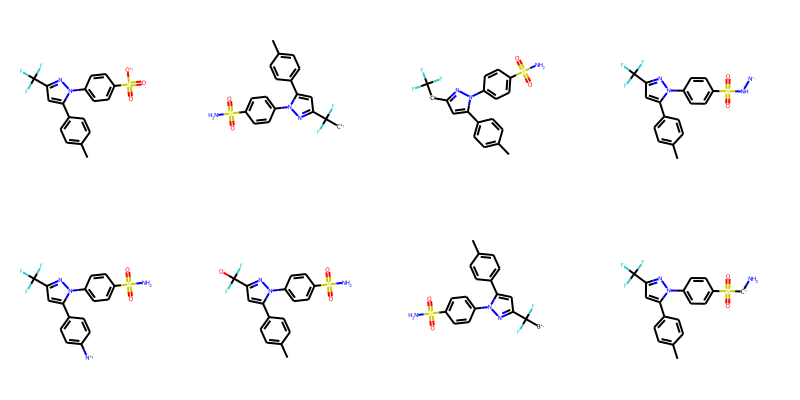

In [4]:
with open("../mols_8.dat", "rb") as f:
    mols_8 = pickle.load(f)

img=Draw.MolsToGridImage(mols_8[:8],molsPerRow=4,subImgSize=(200,200))    
img

In [6]:
from rxitect.models.generator import Generator
import torch

In [8]:
Generator.load_state_dict(torch.load("../models/pretrained_lstm.ckpt"))

TypeError: load_state_dict() missing 1 required positional argument: 'state_dict'